In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import pyro
import pyro.distributions as dist

import time


In [2]:
sample_number = 1000

x1 = np.random.random(sample_number)
x2 = np.sin(np.random.random(sample_number))
y = 2 * x1 
y +=  5 * x2 
y += 0.5 * np.random.randn(sample_number)
data_df = pd.DataFrame({"x1": x1, "x2": x2, "y": y})
data_df

,x1,x2,y
0,0.462119,0.001916,0.400435
1,0.571716,0.486414,3.809251
2,0.149624,0.340182,2.682498
3,0.431080,0.188510,1.592706
4,0.027801,0.672391,3.107277
...,...,...,...
995,0.963868,0.226231,3.394284
996,0.017975,0.569547,2.754159
997,0.671608,0.628464,5.183625
998,0.869289,0.803344,5.461305


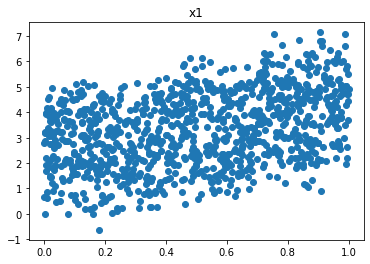

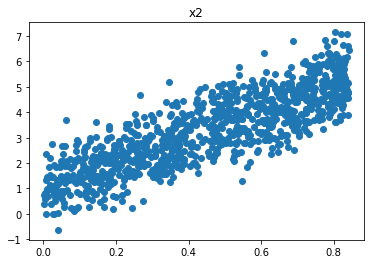

In [3]:
for col in data_df.iloc[:, :-1]:
    plt.figure()
    plt.title(col)
    plt.scatter(data_df[col], y)
    plt.show()

In [4]:
from sklearn.linear_model import LinearRegression

X = data_df.iloc[:, :-1].values
y = data_df.iloc[:, -1].values
my_lr = LinearRegression().fit(X,y)

print(my_lr.score(X,y))
print(my_lr.coef_, my_lr.intercept_)

0.8704137564171183
[2.07022538 5.07779877] -0.038842852736312494


In [5]:
def model(X, y):
    
    #print("sample coef")
    beta_0 = pyro.sample("beta_0", dist.Uniform(0.0, 8.0))
    beta_1 = pyro.sample("beta_1", dist.Uniform(0.0, 8.0))
    beta_2 = pyro.sample("beta_2", dist.Uniform(0.0, 8.0))
    
    
    sigma = pyro.sample("sigma", dist.Uniform(0.0, 8.0))
    
    
    mean = beta_0 + beta_1 * X[:, 0] + beta_2 * X[:, 1]
    
    with pyro.plate("data", len(y)):
        observation = pyro.sample(f"obs", dist.Normal(mean, sigma), obs=y)

In [6]:
from pyro.infer import MCMC, NUTS


pyro.clear_param_store()
my_kernel = NUTS(model)


my_mcmc = MCMC(my_kernel,
               num_samples=2000,
               warmup_steps=100)

X_torch = torch.tensor(X)
y_torch = torch.tensor(y)

start_time = time.time()
my_mcmc.run(X_torch,y_torch)
end_time = time.time()

print(f'took {round(end_time -  start_time, 2)} seconds')

Sample: 100%|██████████| 2100/2100 [01:08, 30.86it/s, step size=8.22e-02, acc. prob=0.951]

took 68.06 seconds


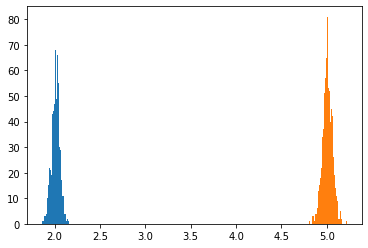

In [7]:
plt.figure()
plt.hist(my_mcmc.get_samples()['beta_1'], bins=100)
plt.hist(my_mcmc.get_samples()['beta_2'], bins=100)
plt.show()

In [8]:
my_mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0      0.03      0.02      0.02      0.00      0.06    893.17      1.00
    beta_1      2.01      0.05      2.02      1.93      2.08   1600.17      1.00
    beta_2      5.01      0.06      5.01      4.92      5.10   1514.83      1.00
     sigma      0.52      0.01      0.52      0.50      0.54   1209.84      1.00

Number of divergences: 0


In [9]:
beta_0_samples = my_mcmc.get_samples()['beta_0'].numpy().reshape(-1, 1)
beta_0_samples.shape

(2000, 1)

In [10]:
beta_1_samples = my_mcmc.get_samples()['beta_1'].numpy().reshape(-1, 1)
beta_1_samples.shape

(2000, 1)

In [11]:
beta_2_samples = my_mcmc.get_samples()['beta_2'].numpy().reshape(-1, 1)
beta_2_samples.shape

(2000, 1)

In [12]:
X.shape

(1000, 2)

In [13]:
y_new = beta_0_samples + beta_1_samples * 0.5 + beta_2_samples * 1.0 

In [14]:
y_new.shape

(2000, 1)

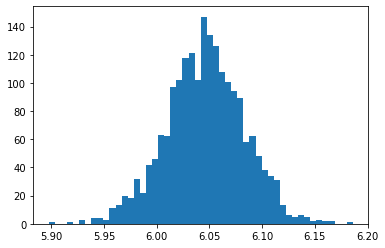

In [15]:
plt.figure()
plt.hist(y_new, bins=50)
plt.show() 